In [1]:
import matplotlib
import numpy as np
from scipy.optimize import root
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

matplotlib.rcParams.update({'font.size': 16, 'legend.loc': 'upper right'})

## Что такое линейные и линеаризованные системы?
https://en.wikipedia.org/wiki/Ordinary_differential_equation#System_of_ODEs

## Почему тема устойчивости важна? Зачем нужны неявные методы?

#### Системы уравнений  
Жесткая:
$$\begin{cases} y_1' = -2  y_1 + y_2 + 2  sin{t} \\
y_2' = 998 y_1 - 999  y_2 + 999  (\cos{t} - \sin{t})
\end{cases}$$

Нежесткая: 
$$\begin{cases}
y_1' = -2  y_1 + y_2 + 2  \sin{t}\\
y_2' = y_1 - 2  y_2 + 2  (\cos{t} - \sin{t}))
\end{cases}$$
Обе системы имеют одинаковое решение:
$$
\begin{cases}
y_1 = 2  e ^ {-t} + \sin{t}\\
y_2 = 2  e ^ {-t} + \cos{t}
\end{cases}$$

#### Функции для правой части систем

In [2]:
def f1(tn, yn):
    return np.array([-2 * yn[0] + yn[1] + 2 * np.sin(tn), 998 * yn[0] - 999 * yn[1] + 999 * (np.cos(tn) - np.sin(tn))])

def f2(tn, yn):
    return np.array([-2 * yn[0] + yn[1] + 2 * np.sin(tn), yn[0] - 2 * yn[1] + 2 * (np.cos(tn) - np.sin(tn))])

#### Получаем решения с фиксированной точностью

In [3]:
t_0 = 0
t_end = 10

y1_0 = 2
y2_0 = 3

tol = 1e-6

explicit_stiff = solve_ivp(f1, [t_0, t_end], [y1_0, y2_0], 'DOP853', rtol=tol)
explicit_non_stiff = solve_ivp(f2, [t_0, t_end], [y1_0, y2_0], 'DOP853', rtol=tol)

implicit_stiff = solve_ivp(f1, [t_0, t_end], [y1_0, y2_0], 'Radau', rtol=tol)
implicit_non_stiff = solve_ivp(f2, [t_0, t_end], [y1_0, y2_0], 'Radau', rtol=tol)

#### Графики

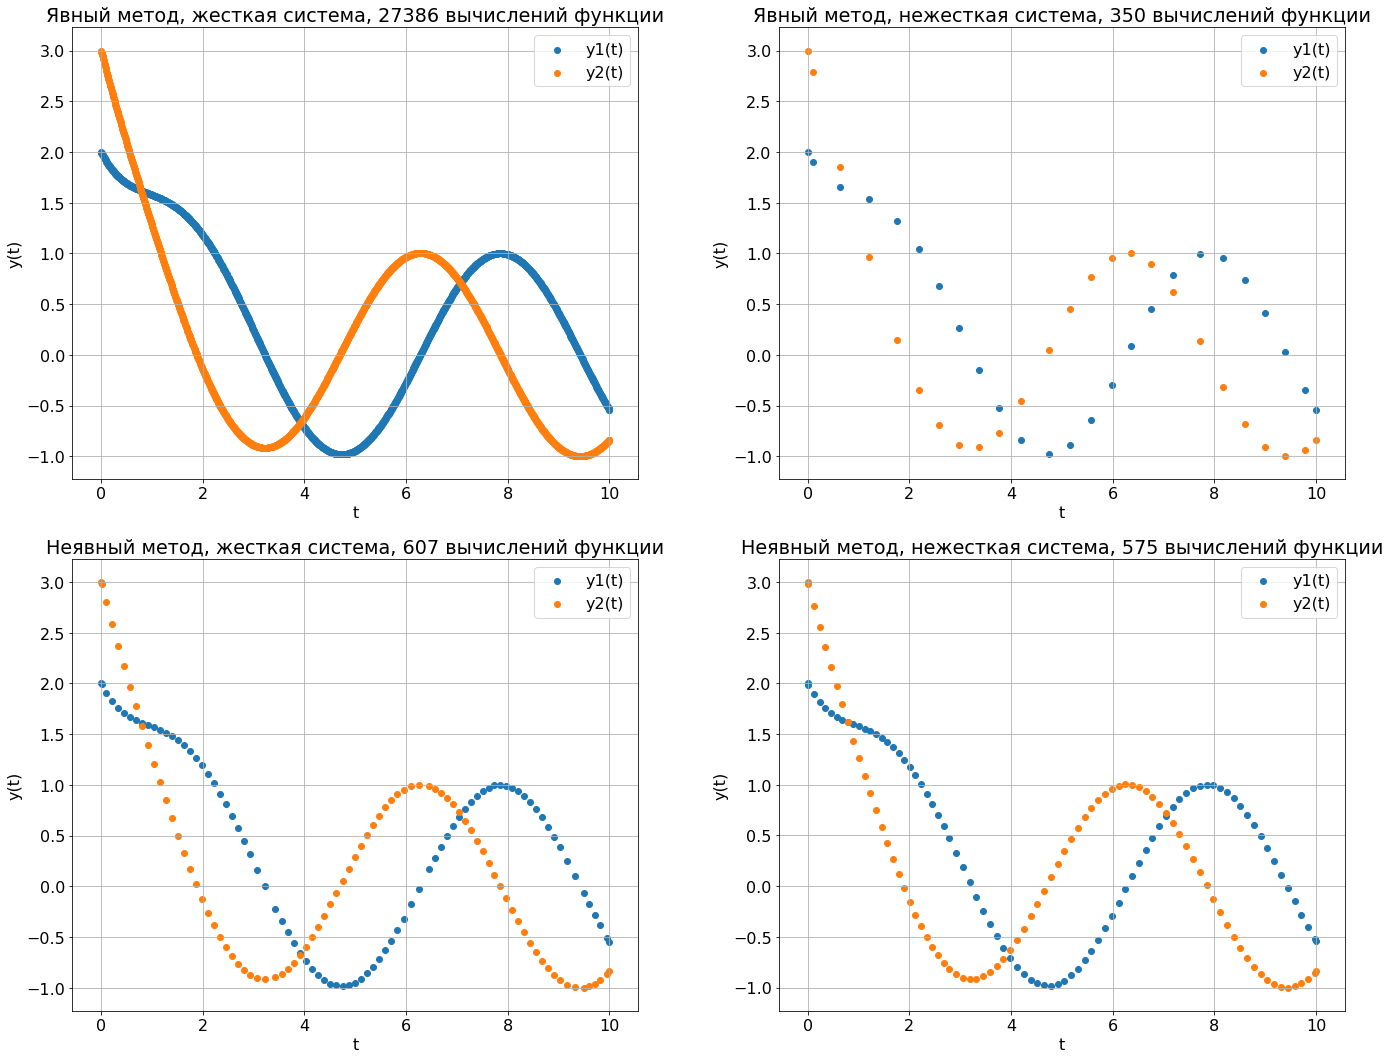

In [4]:
plt.figure(figsize=[20, 15])
            
plt.subplot(2, 2, 1)
plt.grid(True)
plt.title('Явный метод, жесткая система, %s вычислений функции' % (explicit_stiff.nfev))
plt.xlabel('t')
plt.ylabel('y(t)')
plt.scatter(explicit_stiff.t, explicit_stiff.y[0], label='y1(t)')
plt.scatter(explicit_stiff.t, explicit_stiff.y[1], label='y2(t)')
plt.legend()

plt.subplot(2, 2, 2)
plt.grid(True)
plt.title('Явный метод, нежесткая система, %s вычислений функции' % (explicit_non_stiff.nfev))
plt.xlabel('t')
plt.ylabel('y(t)')
plt.scatter(explicit_non_stiff.t, explicit_non_stiff.y[0], label='y1(t)')
plt.scatter(explicit_non_stiff.t, explicit_non_stiff.y[1], label='y2(t)')
plt.legend()

plt.subplot(2, 2, 3)
plt.grid(True)
plt.title('Неявный метод, жесткая система, %s вычислений функции' % (implicit_stiff.nfev))
plt.xlabel('t')
plt.ylabel('y(t)')
plt.scatter(implicit_stiff.t, implicit_stiff.y[0], label='y1(t)')
plt.scatter(implicit_stiff.t, implicit_stiff.y[1], label='y2(t)')
plt.legend()

plt.subplot(2, 2, 4)
plt.grid(True)
plt.title('Неявный метод, нежесткая система, %s вычислений функции' % (implicit_non_stiff.nfev))
plt.xlabel('t')
plt.ylabel('y(t)')
plt.scatter(implicit_non_stiff.t, implicit_non_stiff.y[0], label='y1(t)')
plt.scatter(implicit_non_stiff.t, implicit_non_stiff.y[1], label='y2(t)')
plt.legend()

plt.tight_layout()

## Определим два метода: явный метод (RK4) и неявный метод (Radau IA).

In [5]:
class RungeKutta:

    
    def __init__(self, a, b, c):
        
        assert a.ndim == 2
        assert b.ndim == 1
        assert c.ndim == 1
        assert a.shape[0] == a.shape[1] == b.shape[0] == c.shape[0]                                                                                                                                      
        assert np.isclose(a.sum(1), c).all()
        
        self.s = a.shape[0]
        
        self.a = a.astype(float)
        self.c = c.astype(float)
        self.b = b.astype(float)

        self.is_implicit = (np.triu(a) != 0).any()

        if self.is_implicit:
            self.R = self.R_i1
            self.increment = self.implicit_increment 
        else:
            self.R = self.R_e
            self.increment = self.explicit_increment
        
        
    def system(self, k_des, f, t_n, y_n, h, shape):

        k = k_des.reshape(shape)
        k_cur = np.empty_like(k)
        
        for i in range(self.s):
            k_cur[i] = f(t_n + h * self.c[i], y_n + h * sum(k * self.a[i, :, np.newaxis]))
        
        return (k_cur - k).ravel()

        
    def implicit_increment(self, f, t_n, y_n, h):
        
        shape = self.k.shape
        res = root(self.system, self.k, (f, t_n, y_n, h, shape))

        if not res.success:
            raise Exception('scipy isn`t able to solve system')
        
        self.k = res.x.reshape(shape)
        return h * sum(self.k * self.b[:, np.newaxis])


    def R_i1(self, z):

        e = np.ones(self.s, complex)
        I = np.identity(self.s, complex)
        inv_m = np.linalg.inv(I - z * self.a)

        return 1 + z * self.b @ inv_m @ e
    
    
    def R_i2(self, z):

        e = np.ones(self.s, complex)
        I = np.identity(self.s, complex)
        mmul = e[:, np.newaxis] @ self.b[np.newaxis, :]
        det1 = np.linalg.det(I - z * self.a + z * mmul)
        det2 = np.linalg.det(I - z * self.a)
        
        return det1 / det2
        
        
    def explicit_increment(self, f, t_n, y_n, h):
        
        for i in range(self.s):
            self.k[i] = f(t_n + h * self.c[i], y_n + h * sum(self.k[:i] * self.a[i, :i, np.newaxis]))
        
        return h * sum(self.k * self.b[:, np.newaxis])
        

    def R_e(self, z, p):

        res = 1.
        f_n = 1.
        z_n = complex(z)

        for i in range(p):
            res += z_n / f_n
            f_n *= i + 2
            z_n *= z

        return res
    
    
    def is_B_stable(self):
        
        if not self.is_implicit:
            return 'no'
        
        if (self.b < 0).any():
            return 'maybe'
        
        M = np.empty([self.s, self.s], float)
        
        for i in range(self.s):
            for j in range(self.s):
                M[i, j] = self.b[i] * self.a[i, j] + self.b[j] * self.a[j, i] - self.b[i] * self.b[j]
        
        for i in range(self.s):
            for j in range(i + 1, self.s):
                if np.linalg.det(M[i:j, i:j]) < 0:
                    return 'maybe'
                
        return 'yes'
    
    
    def is_L_stable(self):
        
        if not self.is_implicit:
            return 'no'
        elif np.isclose(self.a[:, 0], self.b).all() or np.isclose(self.a[-1, :], self.b).all():
            return 'yes'
        else:
            return 'maybe'
        
        
    def solve(self, f, t_0, t_end, y_0, h):
       
        assert y_0.ndim == 1
        
        t = []
        y = []
        
        h = float(h)
        t_n = float(t_0)
        t_end = float(t_end)
        y_n = y_0.astype(float)
        n_steps = int((t_end - t_n) / h)
        
        if self.is_implicit:
            self.k = np.full([self.s, y_n.shape[0]], f(t_n, y_n), float)
        else:
            self.k = np.empty([self.s, y_n.shape[0]], float)

        for i in range(n_steps):
            
            t.append(t_n)
            y.append(y_n.copy())
            
            y_n += self.increment(f, t_n, y_n, h)
            t_n += h
            
        t.append(t_n)
        y.append(y_n.copy())

        return np.array(t), np.array(y)

#### Неявный метод Radau IA

In [6]:
c_ria = np.array([0, 2/3])

a_ria = np.array([[1/4, -1/4],
                  [1/4, 5/12]])

b_ria = np.array([1/4, 3/4])

ria = RungeKutta(a_ria, b_ria, c_ria)

#### Явный метод RK4

In [7]:
c_rk4 = np.array([0, 1/2, 1/2, 1])

a_rk4 = np.array([[0,   0,   0,   0],
                  [1/2, 0,   0,   0],
                  [0,   1/2, 0,   0],
                  [0,   0,   1,   0]])

b_rk4 = np.array([1/6, 1/3, 1/3, 1/6])

rk4 = RungeKutta(a_rk4, b_rk4, c_rk4)

## A-stability
Рассмотрим уравнение $y'(x) = k \cdot y(x)$, его решением является $y(x) = e^{k \cdot x} + С$. Возмем шаг $h > 0$, $x_{0} = 0$, $y_{0} = 1$ и решим уравнение числено, тогда для любого метода Рунге-Кутты $y_{n+1} = R(z) * y_{n}$, где $z = h \cdot k$. $R(z)$ называется функцией устойчивости. Если $|R(z)| < 1$, то $\lim\limits_{n \to \infty} y_n = 0$. Множество $\{z \in C | |R(z)| \le 1\}$ называется областью устойчивости. Если область устойчивости включает в себя отрицательную часть компдексной плоскости $C_{-} = \{z \in C | Re(z) \le 0\}$, то метод называется `A-устойчивым`. Область устойчивости любого явного метода является компактом, то есть явный метод не может быть A-устойчивым.    


Для явного и неявного метода Эйлера легко вычислить $ R(z) $ самостоятельно:  

- Явный метод:
$$ y_{n+1} = y_n + h \cdot  f(x_n, y_n)\\
y_{n+1} = y_n + h \cdot k \cdot y_n \\  
y_{n+1} = y_n \cdot (1 + h \cdot k)\\
y_{n+1} = y_n \cdot (1 + z)\\   
R(z) = 1 + z
$$
- Неявный метод:
$$
y_{n+1} = y_n + h \cdot f(x_n, y_{n+1})\\  
y_{n+1} = y_n + h \cdot k \cdot y_{n+1}\\
y_{n+1} \cdot (1 - h \cdot k) = y_n\\  
y_{n+1} = y_n \cdot \frac1{1 - z}\\
R(z) = \frac1{1 - z}  
$$

Есть две формулы для расчета $R(z)$, которые работают для обоих видов методов и одна только для явных методов:  
>- `RungeKutta.R_i1(self, z)`  
>- `RungeKutta.R_i2(self, z)`  
>- `RungeKutta.R_e(self, z, p)` где `p` - порядок точности, для `RK4` `p = 4`

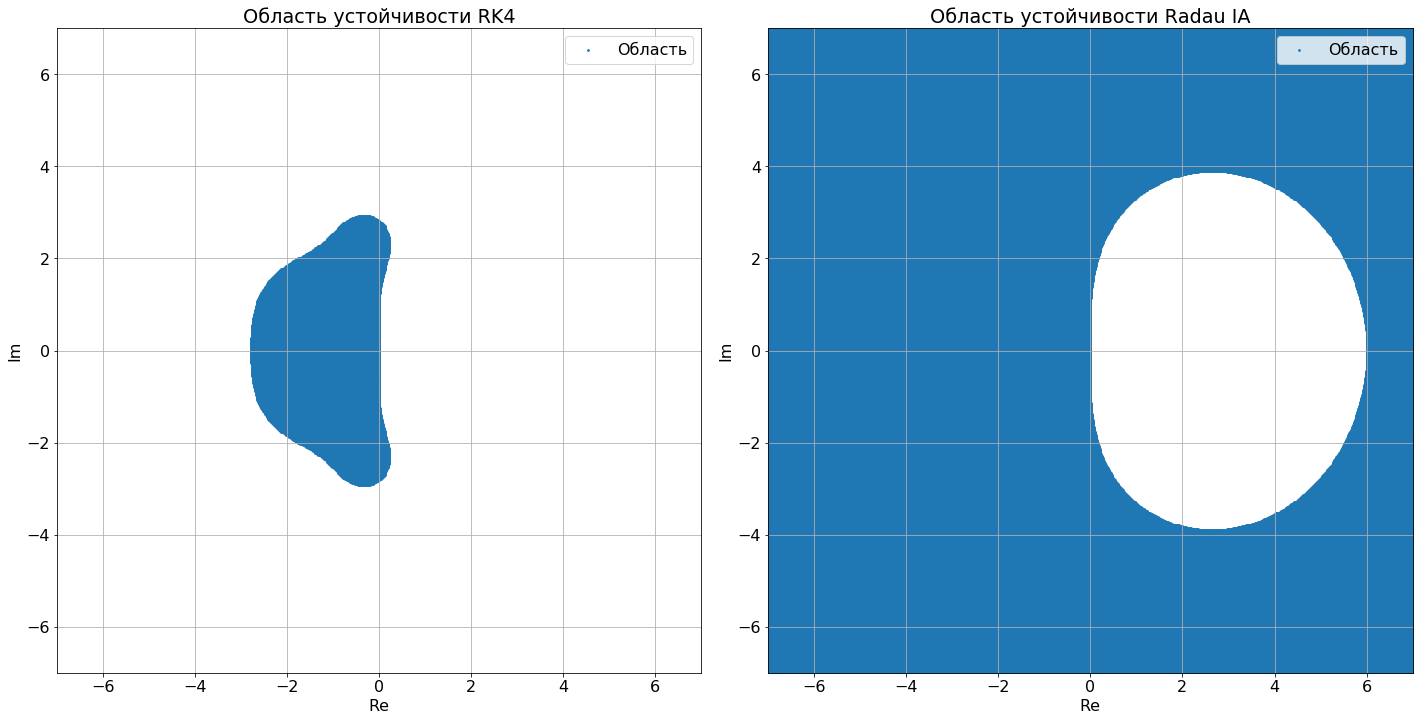

In [8]:
size = 350
scale = 50

plt.figure(figsize=[20, 10])

x = []
y = []

for i in range(-size, size):
    for j in range(-size, size):
        z = complex(i / scale, j / scale)
        if abs(rk4.R_i2(z)) <= 1:
            x.append(i / scale)
            y.append(j / scale)
            
plt.subplot(1, 2, 1)
plt.grid(True)
plt.xlim(-size / scale, size / scale)
plt.ylim(-size / scale, size / scale)
plt.gca().set_aspect('equal')
plt.title('Область устойчивости RK4')
plt.xlabel('Re')
plt.ylabel('Im')
plt.scatter(x, y, 3, label='Область')
plt.legend()

x = []
y = []

for i in range(-size, size):
    for j in range(-size, size):
        z = complex(i / scale, j / scale)
        if abs(ria.R_i2(z)) <= 1:
            x.append(i / scale)
            y.append(j / scale)

plt.subplot(1, 2, 2)
plt.grid(True)
plt.xlim(-size / scale, size / scale)
plt.ylim(-size / scale, size / scale)
plt.gca().set_aspect('equal')
plt.title('Область устойчивости Radau IA')
plt.xlabel('Re')
plt.ylabel('Im')
plt.scatter(x, y, 3, label='Область')
plt.legend()

plt.tight_layout()

Видно, что неявный метод Рунге-Кутта 4-ого порядка А-устойчив

## Примеры
Посмотрим, как работают численные методы Эйлера на примере уравнения $y'(x) = k \cdot y(x)$, $k = -15$, $x_0 = 0$, $y_0 = 1$ при разных величинах шага $h$.

#### Явный Метод Эйлера

In [12]:
c_fe = np.array([0])
a_fe = np.array([[0]])
b_fe = np.array([1])
fe = RungeKutta(a_fe, b_fe, c_fe)

#### Неявный Метод Эйлера

In [10]:
c_be = np.array([1])
a_be = np.array([[1]])
b_be = np.array([1])
be = RungeKutta(a_be, b_be, c_be)

#### Графики

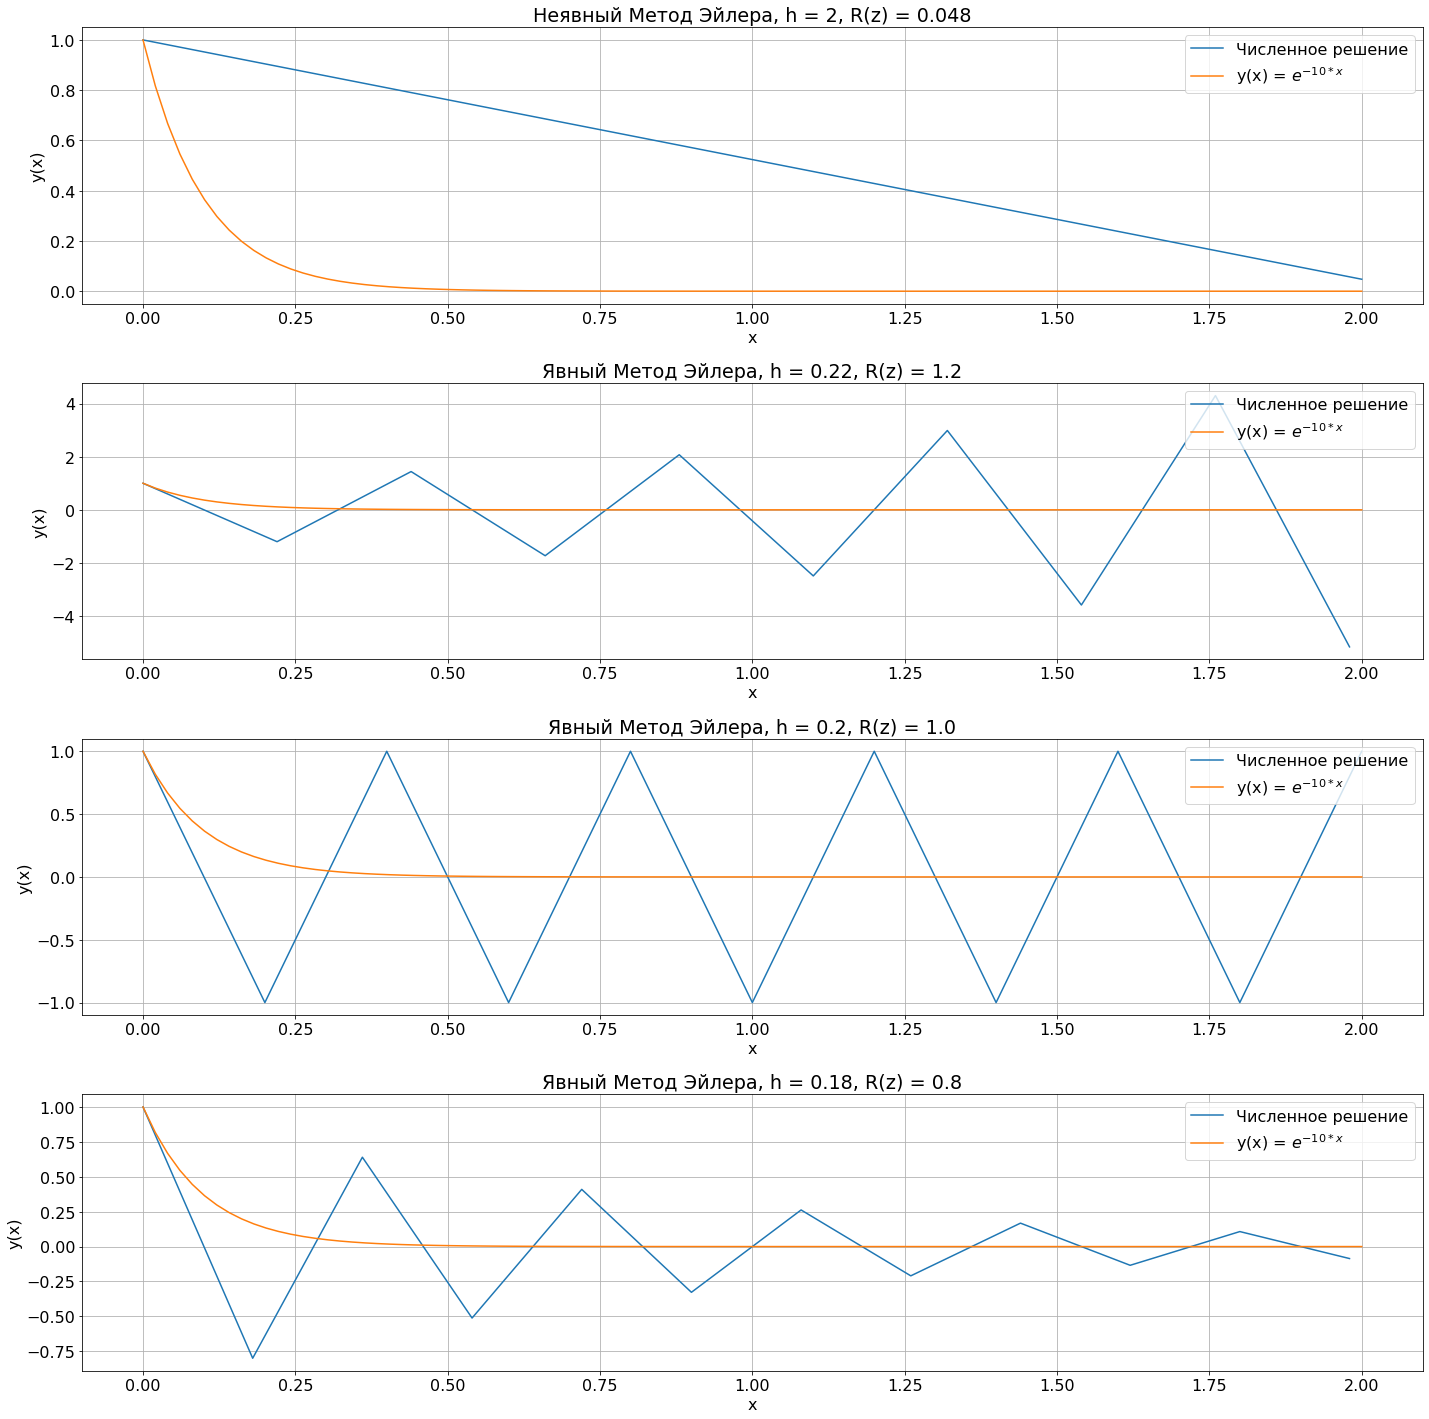

In [20]:
k = -10

def f(tn, yn):    
    return k*yn[0]

t_0 = 0
t_end = 2
y_0 = np.array([1])
x = np.linspace(0, 2, 100)
y = np.e ** (k * x)

plt.figure(figsize=[20, 20])

h = 2
t, yn = be.solve(f, t_0, t_end, y_0, h)

plt.subplot(4, 1, 1)
plt.grid(True)
plt.title('Неявный Метод Эйлера, h = %s, R(z) = %s' % (h, round(abs(be.R_i1(h * k)), 3)))
plt.xlabel('x')
plt.ylabel('y(x)')
plt.plot(t, yn, label='Численное решение')
plt.plot(x, y, label='y(x) = $ e ^ {%s * x} $' % (k))
plt.legend()

h = 0.22
t, yn = fe.solve(f, t_0, t_end, y_0, h)

plt.subplot(4, 1, 2)
plt.grid(True)
plt.title('Явный Метод Эйлера, h = %s, R(z) = %s' % (h, round(abs(fe.R_i1(h * k)), 3)))
plt.xlabel('x')
plt.ylabel('y(x)')
plt.plot(t, yn, label='Численное решение')
plt.plot(x, y, label='y(x) = $ e ^ {%s * x} $' % (k))
plt.legend()

h = 0.2
t, yn = fe.solve(f, t_0, t_end, y_0, h)

plt.subplot(4, 1, 3)
plt.grid(True)
plt.title('Явный Метод Эйлера, h = %s, R(z) = %s' % (h, round(abs(fe.R_i1(h * k)), 3)))
plt.xlabel('x')
plt.ylabel('y(x)')
plt.plot(t, yn, label='Численное решение')
plt.plot(x, y, label='y(x) = $ e ^ {%s * x} $' % (k))
plt.legend()

h = 0.18
t, yn = fe.solve(f, t_0, t_end, y_0, h)

plt.subplot(4, 1, 4)
plt.grid(True)
plt.title('Явный Метод Эйлера, h = %s, R(z) = %s' % (h, round(abs(fe.R_i1(h * k)), 3)))
plt.xlabel('x')
plt.ylabel('y(x)')
plt.plot(t, yn, label='Численное решение')
plt.plot(x, y, label='y(x) = $ e ^ {%s * x} $' % (k))
plt.legend()



plt.tight_layout()

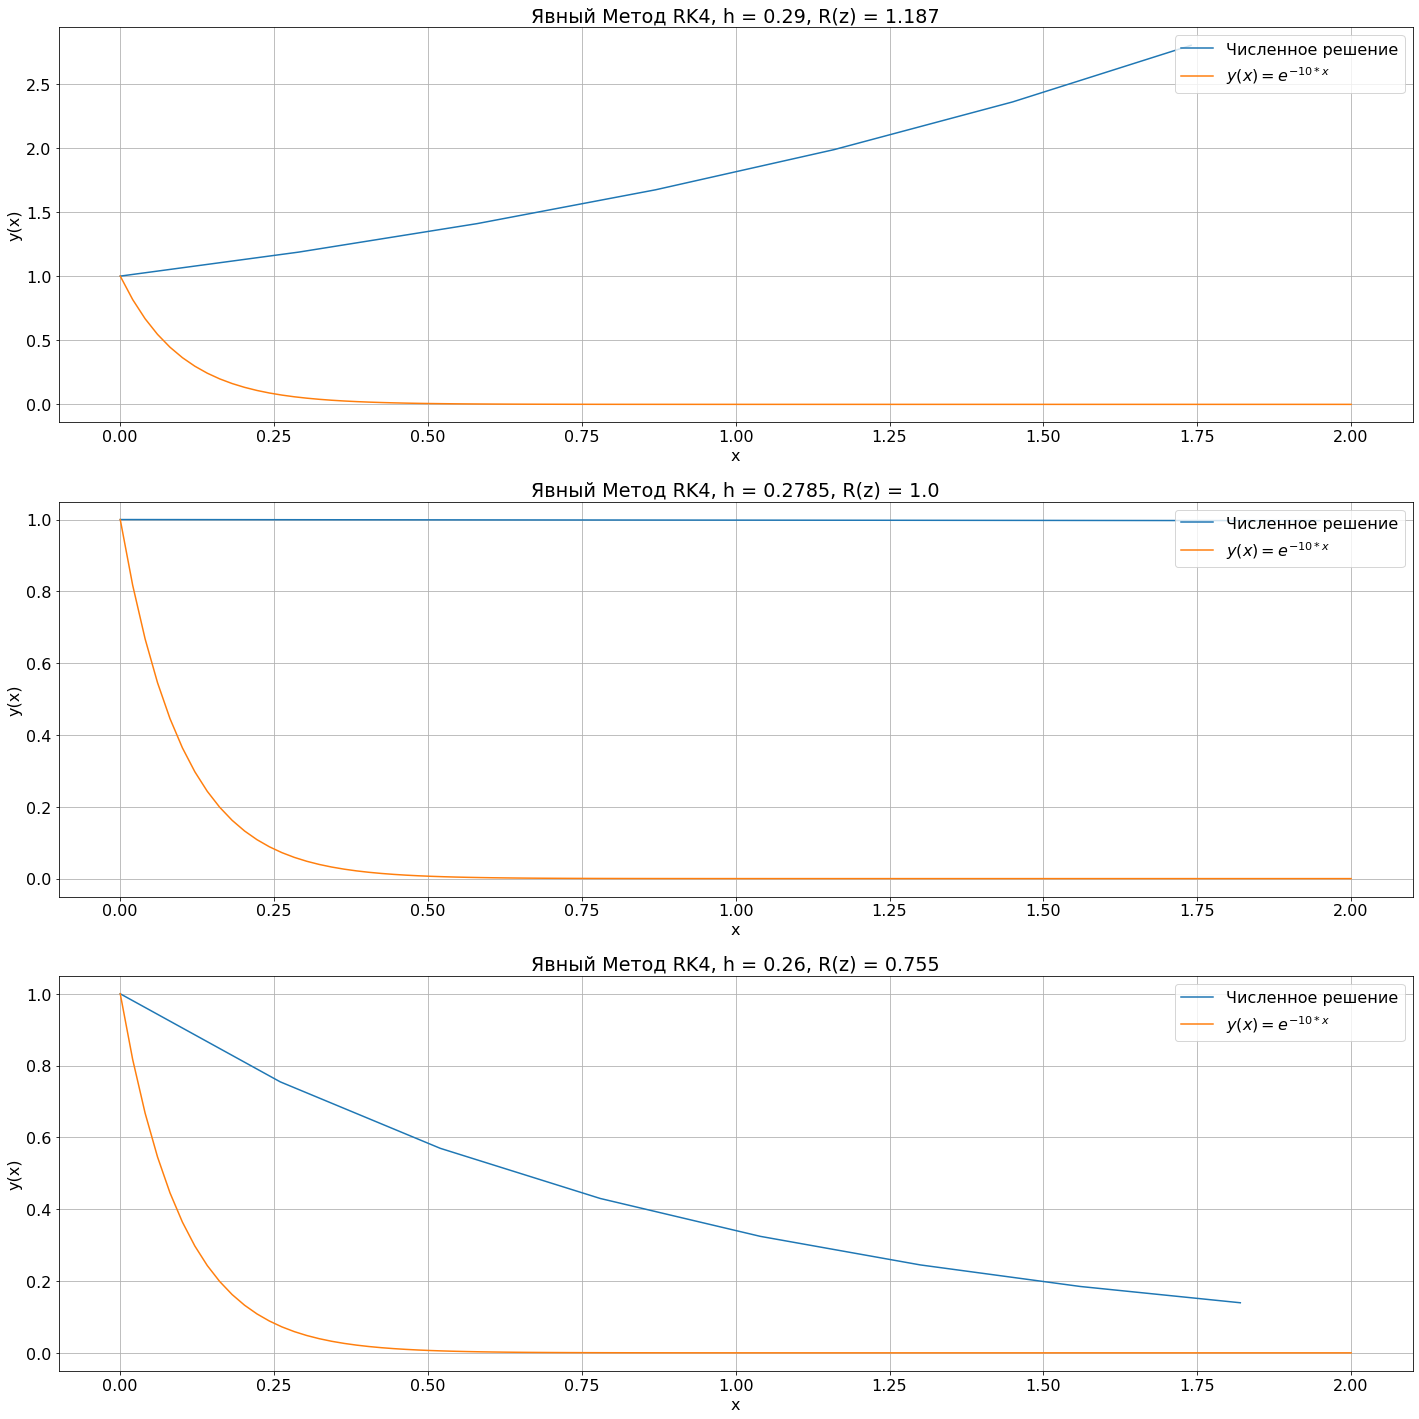

In [22]:
plt.figure(figsize=[20, 20])

h = 0.29
t, yn = rk4.solve(f, t_0, t_end, y_0, h)

plt.subplot(3, 1, 1)
plt.grid(True)
plt.title('Явный Метод RK4, h = %s, R(z) = %s' % (h, round(abs(rk4.R_i1(h * k)), 3)))
plt.xlabel('x')
plt.ylabel('y(x)')
plt.plot(t, yn, label='Численное решение')
plt.plot(x, y, label='$ y(x) = e ^ {%s * x} $' % (k))
plt.legend()

h = 0.2785
t, yn = rk4.solve(f, t_0, t_end, y_0, h)

plt.subplot(3, 1, 2)
plt.grid(True)
plt.title('Явный Метод RK4, h = %s, R(z) = %s' % (h, round(abs(rk4.R_i1(h * k)), 3)))
plt.xlabel('x')
plt.ylabel('y(x)')
plt.plot(t, yn, label='Численное решение')
plt.plot(x, y, label='$ y(x) = e ^ {%s * x} $' % (k))
plt.legend()

h = 0.26
t, yn = rk4.solve(f, t_0, t_end, y_0, h)

plt.subplot(3, 1, 3)
plt.grid(True)
plt.title('Явный Метод RK4, h = %s, R(z) = %s' % (h, round(abs(rk4.R_i1(h * k)), 3)))
plt.xlabel('x')
plt.ylabel('y(x)')
plt.plot(t, yn, label='Численное решение')
plt.plot(x, y, label='$ y(x) = e ^ {%s * x} $' % (k))
plt.legend()

plt.tight_layout()

## B-stability
Возьмем нелинейное уравнение $y' = f(x, y)$. Пусть y(x), z(x) - любые два решения. Метод является B-устойчивым, если из условия $(f(x, y(x)) - f(x, z(x)), y(x) - z(x)) \le 0$ следует, что $\forall h \ge 0 \;\; ||\hat{y_1} - y_1|| \le ||\hat{y_0} - y_0||$, где $\hat{y_1}$ и $y_1$ численные аппроксимации  после одного шага при начальных условиях $\hat{y_0}$ и $y_0$ соответственно. Если метод удовлетворяет двум критериям::
>- $b_{i} \ge 0, i = 1,\ldots,s$  
>- $M = (m_{ij}) = (b_{i} \cdot a_{ij} + b_{j} \cdot a_{ji} - b_{i} \cdot b_{j}), i = 1,\ldots,s, j = 1,\ldots,s$ неотрицательно определена  

то метод является `B-устойчивым`. Можно проверить с помощью метода `RungeKutta.is_B_stable(self)`.

In [12]:
print('Is RK4 B-stable:', rk4.is_B_stable())
print('Is Radau IA B-stable:', ria.is_B_stable())
print('Is forward Euler method B-stable:', fe.is_B_stable())
print('Is backward Euler method B-stable:', be.is_B_stable())

Is RK4 B-stable: no
Is Radau IA B-stable: yes
Is forward Euler method B-stable: no
Is backward Euler method B-stable: yes


## L-stability
Если метод является `A-устойчивым` и $\lim\limits_{z \to \infty}R(z) = 0$, то метод является `L-устойчивым`. Если матрица `a` неявного метода не вырождена и удовлетворяет любому из двух критериев:  
>- $a_{sj} = b_{j}, j = 1,\ldots,s$
>- $a_{i1} = b_{i}, i = 1,\ldots,s$  

то метод является `L-устойчивым`. Можно проверить с помощью метода `RungeKutta.is_L_stable(self)`.

In [13]:
print('Is RK4 L-stable:', rk4.is_L_stable())
print('Is Radau IA L-stable:', ria.is_L_stable())
print('Is forward Euler method L-stable:', fe.is_L_stable())
print('Is backward Euler method L-stable:', be.is_L_stable())

Is RK4 L-stable: no
Is Radau IA L-stable: maybe
Is forward Euler method L-stable: no
Is backward Euler method L-stable: yes


## Order Stars
Область определяется так: $\{z \in C \;\big| \;|R(z)| > |e^z|\}$. Есть много разных теорем, в качестве примера можно привести факт, для явных методов Рунге-Кутты число листов звезды всегда равно порядку точности метода + 1 и при $z\to0$ угловые размеры всех $2 \cdot (p + 1)$ секторов равны 

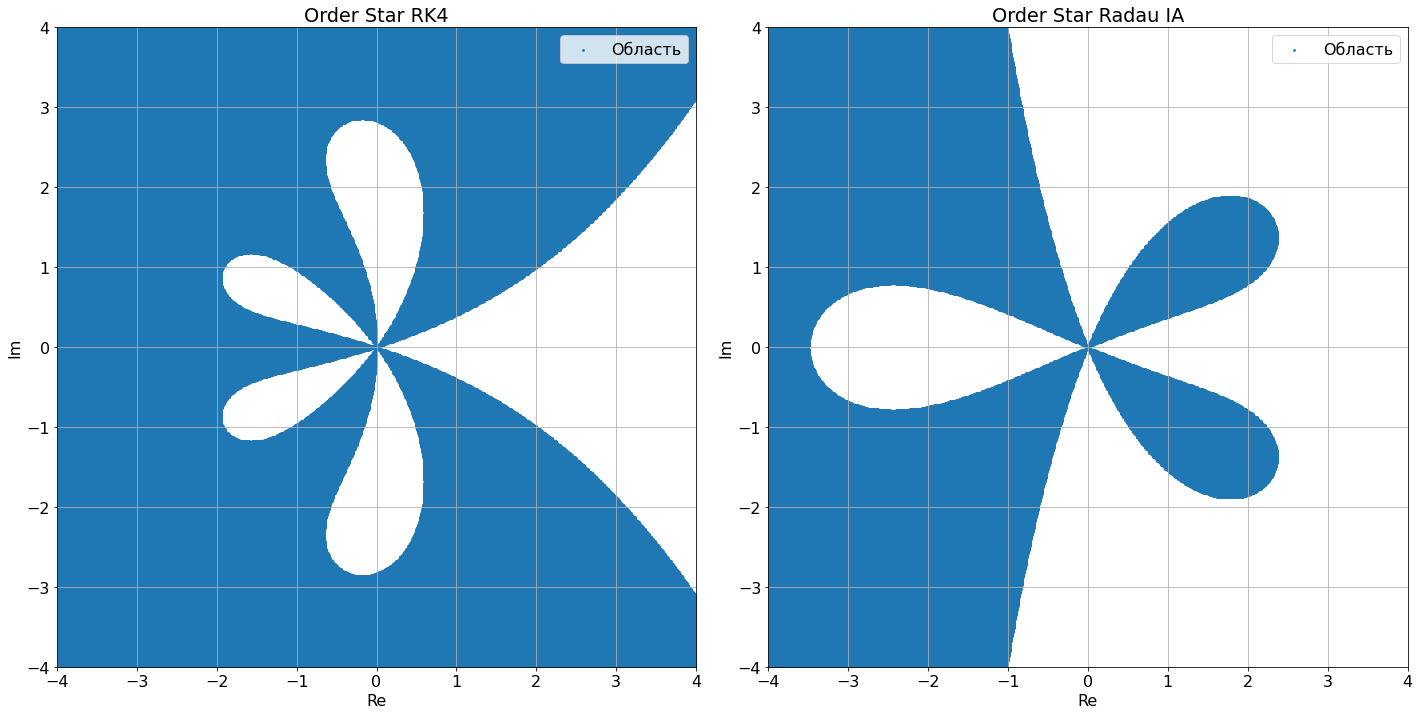

In [14]:
size = 400
scale = 100

plt.figure(figsize=[20, 10])

x = []
y = []

for i in range(-size, size):
    for j in range(-size, size):
        z = complex(i / scale, j / scale)
        if abs(rk4.R_i2(z)) > abs(np.e ** z):
            x.append(i / scale)
            y.append(j / scale)
            
plt.subplot(1, 2, 1)
plt.grid(True)
plt.xlim(-size / scale, size / scale)
plt.ylim(-size / scale, size / scale)
plt.gca().set_aspect('equal')
plt.title('Order Star RK4')
plt.xlabel('Re')
plt.ylabel('Im')
plt.scatter(x, y, 3, label='Область')
plt.legend()

x = []
y = []

for i in range(-size, size):
    for j in range(-size, size):
        z = complex(i / scale, j / scale)
        if abs(ria.R_i2(z)) > abs(np.e ** z):
            x.append(i / scale)
            y.append(j / scale)

plt.subplot(1, 2, 2)
plt.grid(True)
plt.xlim(-size / scale, size / scale)
plt.ylim(-size / scale, size / scale)
plt.gca().set_aspect('equal')
plt.title('Order Star Radau IA')
plt.xlabel('Re')
plt.ylabel('Im')
plt.scatter(x, y, 3, label='Область')
plt.legend()

plt.tight_layout()

## Литература
Hairer, Ernst; Wanner, Gerhard (1991), Solving ordinary differential equations II: Stiff and differential-algebraic problems (стр. 40-59)  
Lambert, J.D (1991), Numerical Methods for Ordinary Differential Systems. The Initial Value Problem (стр. 232-237)  
Iserles, Arieh (1996), A First Course in the Numerical Analysis of Differential Equations (стр. 56-63)  